# Another simple example with `statsmodels`, plus showing how to adjust for over-dispersion

The example is taken from here: https://online.stat.psu.edu/stat504/node/169/

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('./crab.txt', names=["Obs","C","S","W","Wt","Sa"], sep='\s+')

In [3]:
endog_var = endog = df.Sa.values
exog_vars = np.concatenate([np.ones(df.shape[0]).reshape(-1,1),
                            df.W.values.reshape(-1,1)],
                           axis=1)
m = sm.GLM(endog = endog_var,
           exog = exog_vars,
           family = sm.families.Poisson()).fit()

In [4]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      171
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -461.59
Date:                Sun, 12 Apr 2020   Deviance:                       567.88
Time:                        12:11:58   Pearson chi2:                     544.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3048      0.542     -6.095      0.000      -4.368      -2.242
x1             0.1640      0.020      8.216      0.000       0.125       0.203
==============================================================================
"""

In [5]:
df['pred'] = m.predict(exog_vars)
df['lindpred'] = m.predict(exog_vars, linear=True)

note that `m.predict(exog_vars)` is the same as `np.exp(m.predict(exog_vars, linear=True))`

In [6]:
df

,Obs,C,S,W,Wt,Sa,pred,lindpred
0,1,2,3,28.3,3.05,8,3.810341,1.337719
1,2,3,3,26.0,2.60,4,2.612781,0.960415
2,3,3,3,25.6,2.15,0,2.446839,0.894797
3,4,4,2,21.0,1.85,0,1.150492,0.140190
4,5,2,3,29.0,3.00,1,4.274001,1.452550
...,...,...,...,...,...,...,...,...
168,169,2,3,28.3,3.20,0,3.810341,1.337719
169,170,2,3,26.5,2.35,4,2.836122,1.042438
170,171,2,3,26.5,2.75,7,2.836122,1.042438
171,172,3,3,26.1,2.75,3,2.655995,0.976820


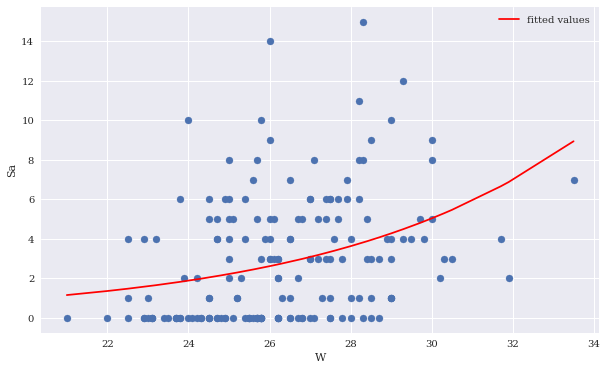

In [7]:
aux = df.copy(deep=True).sort_values('pred').reset_index(drop=True)
f, ax = plt.subplots(1,1, figsize=(10, 6))
ax.scatter(df.W, df.Sa)
ax.plot(aux.W, aux.pred, color='red', label='fitted values')
ax.set_xlabel('W')
ax.set_ylabel('Sa')
ax.legend()
plt.show()

In the context of Logistic regression (same applies to Poisson): https://online.stat.psu.edu/stat504/node/162/

"*When a logistic model fitted to n binomial proportions is satisfactory, the residual deviance has an approximate χ2 distribution with (n – p) degrees of freedom, where p is the number of unknown parameters in the fitted model. Since the expected value of a χ2 distribution is equal to its degree of freedom, it follows that the residual deviance for a well-fitting model should be approximately equal to its degrees of freedom. Equivalently, we may say that the mean deviance (deviance/df) should be close to one. Similarly, if the variance of the data is greater than that under under binomial sampling, the residual mean deviance is likely to be greater than 1.*"

The deviance is the sum of squared **deviance** residuals. The latter, in turn, are defined as (see https://bookdown.org/roback/bookdown-bysh/ch-poissonreg.html )

$\text{sign}(Y_i - \hat{\lambda}_i)\sqrt{2\left[Y_i\log\left(\frac{Y_i}{\hat{\lambda}_i}\right) - (Y_i - \hat{\lambda}_i)\right]}$

In [8]:
logdiff_y_yhat = np.log(endog_var / df.pred).values
logdiff_y_yhat[logdiff_y_yhat==-np.inf] = -99999

deviance_resid = np.sign(endog_var - df.pred) * np.sqrt(2 * (endog_var * logdiff_y_yhat - (endog_var - df.pred) ))

print(m.deviance)
print(np.sum((m.resid_deviance)**2))
print(np.sum((deviance_resid)**2))

567.8785724519456
567.8785724519457
567.8785724519457


/home/seb/py36/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
m.deviance / m.df_resid

3.3209273242803836

In contrast, the Pearson residual is defined as

$\frac{Y_i - \hat{\lambda}_i}{\sqrt{\hat{\lambda}_i}}$

In [10]:
pears_resid = (endog_var - df.pred) / np.sqrt(df.pred)
print(m.pearson_chi2)
print(np.sum((m.resid_pearson)**2))
print(np.sum(pears_resid**2))

544.1570112030288
544.1570112030288
544.1570112030288


## Accounting for overdispersion

We have seen above that $\frac{\text{deviance}}{\text{residual degrees of freedom}}$ = 3.321. I.e. there is overdispersion. To correct for this, the quasi-Poisson model includes a dispersion parameter that scales the variance: $\mathbb{V}(\mu) = \phi\mu$. The estimator of $\phi$ is precisely the Pearson $\chi^2$ scaled by the residual degrees of freedom. ( https://stats.stackexchange.com/questions/314948/quasi-likelihood-quasi-poisson ). To account for over-dispersion, we have to multiply each standard error by $\sqrt{\hat{\phi}}$.

### "old" standard errors

In [11]:
np.sqrt(np.diag(m.cov_params()))

array([0.54224156, 0.01996535])

### over-dispersion adjusted standard errors

Note that these are exactly the same as those by the `R` `glm()` with `family=quasipoisson(link=log)` (see `_2_overdispersion.R` in this repository).

In [12]:
# print(np.sqrt(m.deviance / m.df_resid) * np.sqrt(np.diag(m.cov_params())))
print(np.sqrt(m.pearson_chi2 / m.df_resid) * np.sqrt(np.diag(m.cov_params())))

[0.96729036 0.03561565]


## Robust variance-covariance estimation

A better way than simply assuming over-dispersion is to estimate a robust covariance matrix. The discussion here is worth reading: https://github.com/statsmodels/statsmodels/issues/4942. For the different robust covariance matrices, see here: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults (scroll to bottom). Note that the robust standard errors that we get here are slightly **smaller** than the ones we get from the quasi-poisson model above. 

In [13]:
m = sm.GLM(endog = endog_var,
           exog = exog_vars,
           family = sm.families.Poisson()).fit(cov_type='HC0')

In [14]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      171
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -461.59
Date:                Sun, 12 Apr 2020   Deviance:                       567.88
Time:                        12:11:59   Pearson chi2:                     544.
No. Iterations:                     5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3048      0.840     -3.933      0.000      -4.952      -1.658
x1             0.1640      0.030      5.381      0.000       0.104       0.224
==============================================================================
"""